## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the OCO-2 MIP Top-Down CO₂ Budgets data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

The Committee on Earth Observation Satellites (CEOS) Atmospheric Composition - Virtual Constellation (AC-VC) Greenhouse Gas (GHG) team has generated the CEOS CO₂ Budgets dataset, which provides annual top-down carbon dioxide (CO2) emissions and removals from 2015 - 2020 gridded globally at 1° resolution, and as national totals. Data is provided in units of grams of carbon dioxide per square meter per year (g CO2/m2/yr). Only a subset of the full dataset is displayed in the GHG Center explore view. 

## Installing the required libraries
Please run the cell below to install the libraries required to run this notebook.

In [58]:
%pip install requests
%pip install folium
%pip install rasterstats
%pip install pystac_client

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Querying the STAC API

In [59]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [60]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.
# Name of the collection for CEOS National Top-Down CO₂ Budgets dataset. 
collection_name = "oco2-mip-co2budget-yeargrid-v1"

In [61]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'oco2-mip-co2budget-yeargrid-v1',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'}],
 'title': 'Pilot top-down CO2 Budget constrained by the v10 OCO-2 MIP Version 1',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2015-01-01T00:00:00+00:00',
     '2020-12-31T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'summaries': {'datetime': ['2015-01-01T00:00:00Z', '2020-12-31T00:00:00Z']},
 'description': 'National CO2 Budgets (2015-2020) inferred from

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2015 to December 2020. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is yearly.

In [62]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [63]:
# Check total number of items available
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

Found 6 items


In [64]:
# Examining the first item in the collection
items[0]

{'id': 'oco2-mip-co2budget-yeargrid-v1-2020',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020'}],
 'assets': {'ff': {'href': 's3://ghgc-data-store/oco2-mip-co2budget-yeargrid-v1/pilot_topdown_FF_CO2_Budget_grid_v1_2020.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Fossil fuel and cement emissions',
   'proj:bbox': [-180.0, -90.0, 180.0, 90.0],
   'proj:e

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in CO₂ Levels Using the Raster API

In this notebook, we will explore the global changes of CO₂ budgets over time in urban regions. We will visualize the outputs on a map using `folium.`

In [65]:
# to access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"]: item for item in items} 
asset_name = "ff" #fossil fuel

In [66]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for 2020 and again for 2019, so that we can visualize each event independently.

In [67]:
color_map = "magma"
co2_flux_1 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[0]]['collection']}&item={items[list(items.keys())[0]]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
co2_flux_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=oco2-mip-co2budget-yeargrid-v1&item=oco2-mip-co2budget-yeargrid-v1-2020&assets=ff&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C25762.3125'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [68]:
co2_flux_2 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[list(items.keys())[1]]['collection']}&item={items[list(items.keys())[1]]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
co2_flux_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=oco2-mip-co2budget-yeargrid-v1&item=oco2-mip-co2budget-yeargrid-v1-2019&assets=ff&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C25762.3125'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualizing CO₂ Emissions

In [69]:
# We'll import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for CO₂ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)


map_layer_2020 = TileLayer(
    tiles=co2_flux_1["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2020.add_to(map_.m1)

map_layer_2019 = TileLayer(
    tiles=co2_flux_2["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2019.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [70]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [71]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [72]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 6 items


In [73]:
# Explore the first item
items[0]

{'id': 'oco2-mip-co2budget-yeargrid-v1-2020',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020'}],
 'assets': {'ff': {'href': 's3://ghgc-data-store/oco2-mip-co2budget-yeargrid-v1/pilot_topdown_FF_CO2_Budget_grid_v1_2020.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Fossil fuel and cement emissions',
   'proj:bbox': [-180.0, -90.0, 180.0, 90.0],
   'proj:e

In [74]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    print(result)
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

In [75]:
for item in items:
    print(item["properties"]["start_datetime"])
    break

2020-01-01T00:00:00+00:00


With the function above we can generate the statistics for the AOI.

In [76]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'properties': {'statistics': {'b1': {'min': 0.03978176414966583, 'max': 7348.5, 'mean': 710.6574534496499, 'count': 36.0, 'sum': 25583.668324187398, 'std': 1398.048920955156, 'median': 92.79795837402344, 'majority': 0.03978176414966583, 'minority': 0.03978176414966583, 'unique': 36.0, 'histogram': [[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.03978176414966583, 734.8858035877347, 1469.7318254113197, 2204.5778472349048, 2939.42386905849, 3674.269890882075, 4409.11591270566, 5143.961934529245, 5878.80795635283, 6613.653978176415, 7348.5]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 36.0, 'percentile_2': 0.7717349633574486, 'percentile_98': 4147.699072265612}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-95.0, 29.0], [-95.0, 33.0], [-104.0, 33.0], [-104.0, 29.0], [-95.0, 29.0]]]}, 'pro

In [77]:
stats[0]

{'statistics': {'b1': {'min': 0.03978176414966583,
   'max': 7348.5,
   'mean': 710.6574534496499,
   'count': 36.0,
   'sum': 25583.668324187398,
   'std': 1398.048920955156,
   'median': 92.79795837402344,
   'majority': 0.03978176414966583,
   'minority': 0.03978176414966583,
   'unique': 36.0,
   'histogram': [[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [0.03978176414966583,
     734.8858035877347,
     1469.7318254113197,
     2204.5778472349048,
     2939.42386905849,
     3674.269890882075,
     4409.11591270566,
     5143.961934529245,
     5878.80795635283,
     6613.653978176415,
     7348.5]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 36.0,
   'percentile_2': 0.7717349633574486,
   'percentile_98': 4147.699072265612}},
 'datetime': '2020-01-01T00:00:00+00:00'}

In [78]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,0.039782,7348.500000,710.657453,36.0,25583.668324,1398.048921,92.797958,0.039782,0.039782,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.771735,4147.699072,2020-01-01 00:00:00+00:00
1,2019-01-01T00:00:00+00:00,0.091393,8174.177246,795.299751,36.0,28630.791028,1557.578314,108.243446,0.091393,0.091393,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.949963,4609.885083,2019-01-01 00:00:00+00:00
2,2018-01-01T00:00:00+00:00,0.091512,8392.841797,816.330697,36.0,29387.905075,1599.111075,110.892628,0.091512,0.091512,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.972050,4733.363477,2018-01-01 00:00:00+00:00
3,2017-01-01T00:00:00+00:00,0.091022,8138.964844,791.945597,36.0,28510.041476,1550.823779,107.778057,0.091022,0.091022,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.972684,4589.991333,2017-01-01 00:00:00+00:00
4,2016-01-01T00:00:00+00:00,0.088426,8243.259766,801.738824,36.0,28862.597653,1570.489286,108.757420,0.088426,0.088426,36.0,"[[28.0, 2.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0...",100.0,0.0,36.0,0.987191,4649.222046,2016-01-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the fossil fuel emission time series (January 2015 -December 2020) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CO2 emission Values for Texas, Dallas (2015-2020)')

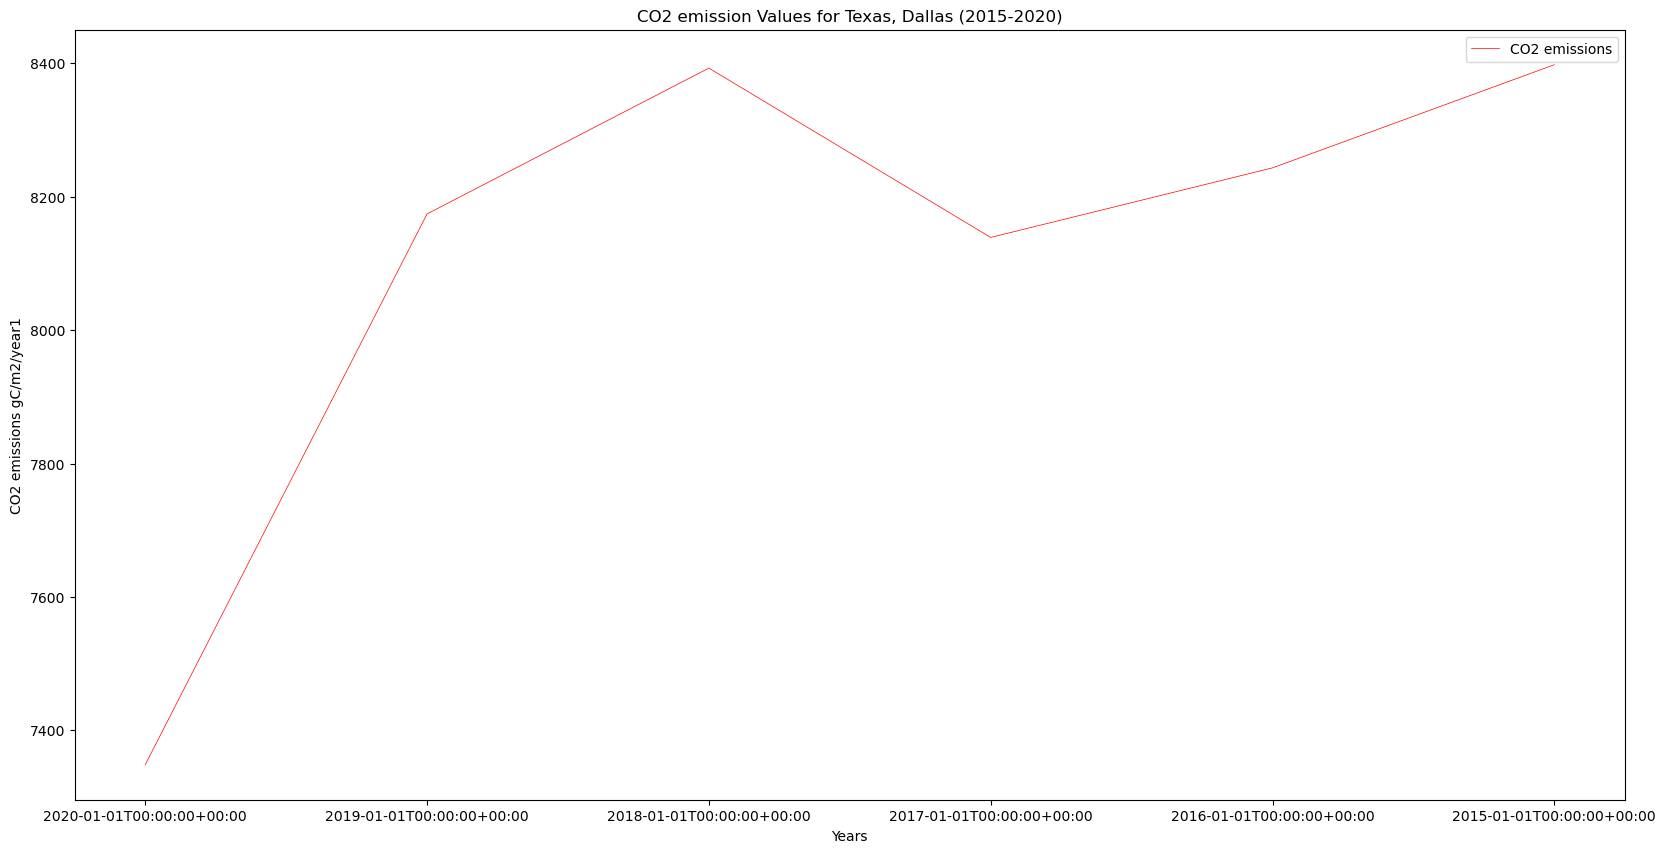

In [79]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["datetime"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="CO2 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CO2 emissions gC/m2/year1")
plt.title("CO2 emission Values for Texas, Dallas (2015-2020)")

In [80]:
print(items[2]["properties"]["start_datetime"])

2018-01-01T00:00:00+00:00


In [81]:
co2_flux_3 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
co2_flux_3

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=oco2-mip-co2budget-yeargrid-v1&item=oco2-mip-co2budget-yeargrid-v1-2018&assets=ff&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C25762.3125'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [82]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6.8,
)

map_layer = TileLayer(
    tiles=co2_flux_3["tiles"][0],
    attr="GHG", opacity = 0.7
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for OCO-2 MIP Top-Down CO₂ Budgets.